<a href="https://colab.research.google.com/github/raphaelchaves/papa-linguas/blob/main/Projeto_PLN_ICMC_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://4.bp.blogspot.com/-tbAWK7KCPq0/TbVg-SmjNFI/AAAAAAAAAtQ/QboG2_SDuNo/s1600/logo+fiinal.jpg" width="300">


#Análise de Sentimentos

Projeto sobre análise de sentimentos desenvolvido como parte da disciplina de Processamento em Língua Natural. ICMC-USP

## Principais Etapas:
1. **Coleta de Dados**
2. **Pré-processamento de Dados**
3. **Nuvem de Palavras**
4. **Remoção de Stop Words**
5. **Tokenização**
6. **Análise Exploratória dos Dados**
7. **Lematização**
8. **Variável Target**
9. **Análise de Desbalanceamento**
10. **Processo de Vetorização (WordVec)**
11. **Divisão dos dados - Treino e Teste**
12. **Balanceamento de Classes**
13. **Treinar o Modelo**
14. **Testar o Modelo**
15. **Simular Classificação**

### Carregando Bibliotecas Necessárias:


In [1]:
# Step 1: Uninstall the current version of NumPy
#!pip uninstall -y numpy

# Step 2: Install a compatible version of NumPy
#!pip install numpy==1.23.5

# Step 3: Reinstall other required libraries
!pip install --force-reinstall scipy gensim spacy nltk


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 942.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.2/65.2 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 1.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 49.2 

In [1]:
import numpy as np
import gensim
from gensim.models import Word2Vec
import spacy
import requests
import io
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import RSLPStemmer

### 1ª Etapa: Coleta de Dados


In [2]:
# Define the URL of the CSV file
url = "https://raw.githubusercontent.com/americanas-tech/b2w-reviews01/main/B2W-Reviews01.csv"

# Lendo o arquivo csv num pandas dataframe
try:
    original_data = pd.read_csv(url)
    print("DataFrame loaded successfully!")
except Exception as e:
    print(f"An error occurred: {e}")

DataFrame loaded successfully!


<ipython-input-2-d3fd4e2e24eb>:6: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  original_data = pd.read_csv(url)


In [4]:
# Armazena dataset original no Google Drive
# Passo 1: Monta conexão com Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Passo 2: Define 0 caminho onde o dataframe será salvo no Google Drive
save_path = '/content/drive/My Drive/ICMC/PLN/original_data.pkl'

# Passo 3: Salva o dataframe utilizando pickle
original_data.to_pickle(save_path)
print(f"DataFrame exportado com sucesso para {save_path}")

DataFrame exportado com sucesso para /content/drive/My Drive/ICMC/PLN/original_data.pkl


In [6]:
# Exibe o conteúdo de um Paandas dataFrame (df) em formato de uma tabela HTML
display(HTML(original_data.to_html(max_rows=10)))

,submission_date,reviewer_id,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,overall_rating,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state
0,2018-01-01 00:11:28,d0fb1ca69422530334178f5c8624aa7a99da47907c44de0243719b15d50623ce,132532965,"Notebook Asus Vivobook Max X541NA-GO472T Intel Celeron Quad Core 4GB 500GB Tela LED 15,6"" Windows - 10 Branco",NaN,Informática,Notebook,Bom,4,Yes,Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.,1958.0,F,RJ
1,2018-01-01 00:13:48,014d6dc5a10aed1ff1e6f349fb2b059a2d3de511c7538a9008da562ead5f5ecd,22562178,Copo Acrílico Com Canudo 500ml Rocie,NaN,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",4,Yes,"Por apenas R$1994.20,eu consegui comprar esse lindo copo de acrílico.",1996.0,M,SC
2,2018-01-01 00:26:02,44f2c8edd93471926fff601274b8b2b5c4824e386ae4f210329b9b71890277fd,113022329,Panela de Pressão Elétrica Philips Walita Daily 5L com Timer,philips walita,Eletroportáteis,Panela Elétrica,ATENDE TODAS AS EXPECTATIVA.,4,Yes,"SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANELAS ELÉTRICAS. COSTUMO USAR OUTRA PANELA PARA COZIMENTO DE ARROZ (JAPONESA), MAS LEVA MUITO TEMPO, +/- 50 MINUTOS. NESSA PANELA É MUITO MAIS RÁPIDO, EXATAMENTE 6 MINUTOS. EU RECOMENDO.",1984.0,M,SP
3,2018-01-01 00:35:54,ce741665c1764ab2d77539e18d0e4f66dde6213c9f0863f165ffedb1e8147984,113851581,Betoneira Columbus - Roma Brinquedos,roma jensen,Brinquedos,Veículos de Brinquedo,presente mais que desejado,4,Yes,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS DETALHES QUE TÊM!,1985.0,F,SP
4,2018-01-01 01:00:28,7d7b6b18dda804a897359276cef0ca252f9932bf4b5c8e72bce7e88850efa0fc,131788803,"Smart TV LED 43"" LG 43UJ6525 Ultra HD 4K com Conversor Digital 4 HDMI 2 USB WebOS 3.5 Painel Ips HDR e Magic Mobile Connection",lg,TV e Home Theater,TV,"Sem duvidas, excelente",5,Yes,"A entrega foi no prazo, as americanas estão de parabéns. A smart tv é muito boa, a navegação na internete e pelos aplicativos e excelente, não trava, sem falar da imagem que é de surpreender. recomendo.",1994.0,M,MG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132368,2018-05-31 23:30:50,15f20e95ff44163f3175aaf67a5ae4a94d5030b409e5211bd0511ae5744325aa,17962233,Carregador De Pilha Sony + 4 Pilhas Aa 2500mah,NaN,Câmeras e Filmadoras,Acessórios para Câmeras e Filmadoras,Ótimo produto!,5,Yes,"Vale muito, estou usando no controle do Xbox e me durou uma semana a carga de um par, e isso jogando todos os dias!",1988.0,M,RS
132369,2018-05-31 23:42:25,def7cf9028b0673ab8bca3b1d06e085461fafb88cd48d9354ecdd9617a0bb3e0,132631701,Mop Giratório Fit + Refil Extra - At Home,NaN,Utilidades Domésticas,Material de Limpeza,Sensacional,5,Yes,"Prático e barato, super indico o produto para quem corre no seu dia a dia, fora que o prazo de entrega foi bem rápida.",1979.0,F,SP
132370,2018-05-31 23:44:16,7bcbf542f5d7dd9a9a192a6805adba7a7a4c1ce3bf00df4cc3c46133983b35d9,16095859,Fita Led 5m Rgb 3528 Siliconada Com 300 Leds Controle Fonte,NaN,Automotivo,Iluminação,Ótimo produto,4,Yes,Chegou antes do prazo previsto e corresponde ao anúncio,1979.0,F,PR
132371,2018-05-31 23:46:48,e6fb0b19277d01c2a300c7837a105f3c369377e92f9c19ed7b03889ad1ce5509,6774907,Etiquetas Jurídicas Vade Mecum - Marca Fácil,marca facil,Papelaria,Material de Escritório,O produto não é bom.,1,No,"Material fraco, poderia ser melhor. Ficou devendo na minha opinião.",1991.0,M,RJ


### 2ª Etapa: Inicia Pré-Processamento dos Dados:

In [7]:
# Cria um novo dataframe chamado "development_sample" contendo apenas os atributos relevantes para a análise de sentimentos

development_sample = original_data[['review_text', 'overall_rating', 'recommend_to_a_friend', 'site_category_lv1', 'site_category_lv2','review_title', 'reviewer_state', 'reviewer_gender']]

In [8]:
# O atributo "review title", introduz ou sumariza a revisão do cliente, enquanto que o atributo "review_text" contempla todo o comentário do cliente sobre um determinado produto, seja ele positivo ou negativo. Considerando que ambos os atributos expressam uma opinião do cliente, estamos criando um novo campo chamado "customer_review_text", o qual contempla as opiniões expressas nestes 2 campos.
development_sample['customer_review_text'] = development_sample['review_title'] + ' ' + development_sample['review_text']

<ipython-input-8-e24d732c6db5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  development_sample['customer_review_text'] = development_sample['review_title'] + ' ' + development_sample['review_text']


In [9]:
# Remove valores NaN
development_sample.dropna(inplace = True)

<ipython-input-9-e7a227a0e639>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  development_sample.dropna(inplace = True)


In [10]:
# Remove Dados Duplicados
development_sample.drop_duplicates(keep='first', inplace=True)

<ipython-input-10-58d05a2e10c2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  development_sample.drop_duplicates(keep='first', inplace=True)


In [11]:
# Cria um novo atributo na qual o texto será convertido apenas para letras minúsculas
development_sample['review_text_preprocessed'] = development_sample['customer_review_text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

<ipython-input-11-93995e0588dc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  development_sample['review_text_preprocessed'] = development_sample['customer_review_text'].apply(lambda x: " ".join(x.lower() for x in x.split()))


In [12]:
# Remover pontuação e adicionar espaço usando expressões regulares (Noise)
development_sample['review_text_preprocessed'] = development_sample['review_text_preprocessed'].str.replace(r'[^\w\s]', ' ', regex=True)


<ipython-input-12-90c0f2111de6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  development_sample['review_text_preprocessed'] = development_sample['review_text_preprocessed'].str.replace(r'[^\w\s]', ' ', regex=True)


In [13]:
# Remove números
development_sample['review_text_preprocessed'] = development_sample['review_text_preprocessed'].str.replace('\d+', ' ', regex=True)

<ipython-input-13-71d6db2a0748>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  development_sample['review_text_preprocessed'] = development_sample['review_text_preprocessed'].str.replace('\d+', ' ', regex=True)


In [14]:
# O atributo rating representa a revisão dos clientes que se baseia no seguinte mapeamento:
mapping = {1: 'Ruim', 2: 'Regular', 3: 'Bom', 4: 'Ótimo', 5: 'Excelente'}

development_sample['customer_review_rating'] = development_sample['overall_rating'].map(mapping)

display(HTML(development_sample.to_html(max_rows=100)))

<ipython-input-14-199e86b1b294>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  development_sample['customer_review_rating'] = development_sample['overall_rating'].map(mapping)


,review_text,overall_rating,recommend_to_a_friend,site_category_lv1,site_category_lv2,review_title,reviewer_state,reviewer_gender,customer_review_text,review_text_preprocessed,customer_review_rating
0,Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.,4,Yes,Informática,Notebook,Bom,RJ,F,Bom Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.,bom estou contente com a compra entrega rápida o único problema com as americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera,Ótimo
1,"Por apenas R$1994.20,eu consegui comprar esse lindo copo de acrílico.",4,Yes,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",SC,M,"Preço imbatível, ótima qualidade Por apenas R$1994.20,eu consegui comprar esse lindo copo de acrílico.",preço imbatível ótima qualidade por apenas r eu consegui comprar esse lindo copo de acrílico,Ótimo
2,"SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANELAS ELÉTRICAS. COSTUMO USAR OUTRA PANELA PARA COZIMENTO DE ARROZ (JAPONESA), MAS LEVA MUITO TEMPO, +/- 50 MINUTOS. NESSA PANELA É MUITO MAIS RÁPIDO, EXATAMENTE 6 MINUTOS. EU RECOMENDO.",4,Yes,Eletroportáteis,Panela Elétrica,ATENDE TODAS AS EXPECTATIVA.,SP,M,"ATENDE TODAS AS EXPECTATIVA. SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANELAS ELÉTRICAS. COSTUMO USAR OUTRA PANELA PARA COZIMENTO DE ARROZ (JAPONESA), MAS LEVA MUITO TEMPO, +/- 50 MINUTOS. NESSA PANELA É MUITO MAIS RÁPIDO, EXATAMENTE 6 MINUTOS. EU RECOMENDO.",atende todas as expectativa supera em agilidade e praticidade outras panelas elétricas costumo usar outra panela para cozimento de arroz japonesa mas leva muito tempo minutos nessa panela é muito mais rápido exatamente minutos eu recomendo,Ótimo
3,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS DETALHES QUE TÊM!,4,Yes,Brinquedos,Veículos de Brinquedo,presente mais que desejado,SP,F,presente mais que desejado MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS DETALHES QUE TÊM!,presente mais que desejado meu filho amou parece de verdade com tantos detalhes que têm,Ótimo
4,"A entrega foi no prazo, as americanas estão de parabéns. A smart tv é muito boa, a navegação na internete e pelos aplicativos e excelente, não trava, sem falar da imagem que é de surpreender. recomendo.",5,Yes,TV e Home Theater,TV,"Sem duvidas, excelente",MG,M,"Sem duvidas, excelente A entrega foi no prazo, as americanas estão de parabéns. A smart tv é muito boa, a navegação na internete e pelos aplicativos e excelente, não trava, sem falar da imagem que é de surpreender. recomendo.",sem duvidas excelente a entrega foi no prazo as americanas estão de parabéns a smart tv é muito boa a navegação na internete e pelos aplicativos e excelente não trava sem falar da imagem que é de surpreender recomendo,Excelente
5,"Excelente produto, por fora em material acrílico super resistente e por dentro em adamantio, faz milagre com qualquer bebida. Sugiro aproveitarem a promoção antes que acabe.",5,Yes,Utilidades Domésticas,"Copos, Taças e Canecas",Produto imperdível,PA,M,"Produto imperdível Excelente produto, por fora em material acrílico super resistente e por dentro em adamantio, faz milagre com qualquer bebida. Sugiro aproveitarem a promoção antes que acabe.",produto imperdível excelente produto por fora em material acrílico super resistente e por dentro em adamantio faz milagre com qualquer bebida sugiro aproveitarem a promoção antes que acabe,Excelente
7,Produto excelente qualidade boa câmera desenvolvimento do Android com rapidez,4,Yes,Celulares e Smartphones,Smartphone,Gostei bastante do produto,GO,M,Gostei bastante do produto Produto excelente qualidade boa câmera desenvolvimento do Android com rapidez,gostei bastante do produto produto excelente qualidade boa câmera desenvolvimento do android com rapidez,Ótimo
8,O barulho e minimo e o vento 

### 3ª Etapa: Nuvem de Palavras

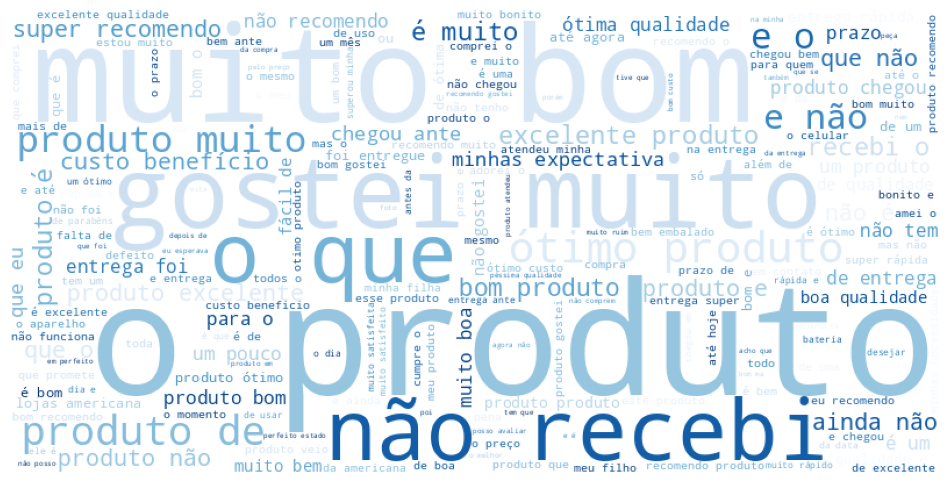

In [15]:
# Neste momento, não aplicamos a "Lematização", dado que a Nuvem de Palavras não deve mostrar palavras cortadas ou reduzidas, sob o risco de perder seu sentido. Portanto, aplicamos somente o pré-processamento e limpeza inicial dos dados. A remoção de stopwords será feita em seguida.

# Combina todos os comentários numa string única
text = ' '.join(development_sample['review_text_preprocessed'])

# Cria a Nuvem de Palavras
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Blues_r').generate(text)

# Plotando a Nuvem de Palavras
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### 4ª Etapa: Remoção de Stop Words

**Objetivo:**
Na análise de sentimentos, a etapa de remoção de stop words é uma etapa fundamental do pré-processamento de texto. Stop words são palavras que, em geral, não agregam significado relevante ao contexto do texto quando analisado em um modelo de análise de sentimentos ou outras tarefas de Processamento de Linguagem Natural (PLN).

**1) O que são stop words?**

Stop words são palavras muito comuns que geralmente são removidas durante o pré-processamento de texto. Estas palavras são necessárias para a estrutura gramatical das frases, mas não carregam informações significativas em termos de análise de sentimentos ou outras tarefas de NLP. Em português, algumas dessas palavras incluem:
*   Pronomes: eu, você, ele, ela, nós, eles, etc.
*   Artigos: o, a, os, as, um, uma, uns, umas.
*   Preposições: de, em, para, com, por, sobre, etc.
*   Conjunções: e, mas, ou, porque, que, etc.
*   Outras palavras comuns: muito, pouco, tudo, algo, etc.


Por exemplo:

Frase: "Eu gosto muito de chocolate."

Sem stop words: "gosto chocolate."

Nesse caso, palavras como "Eu", "muito", "de" não ajudam diretamente a identificar o sentimento (positivo ou negativo) da frase. O que é mais importante para identificar o sentimento aqui é "gosto" e "chocolate".


In [16]:
# Efetua download de stopwords da  biblioteca nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [17]:
# Obter todas as stop_words em português, criando uma lista personalizada
stop_words = set(stopwords.words('portuguese'))

In [18]:
nltk.download('punkt_tab')

# Cria uma lista de tokens temporários'
development_sample['tokens_list_tmp'] = development_sample['review_text_preprocessed'].apply(lambda x: word_tokenize(x.lower()))

# Apresenta os 5 casos como exemplo
display(HTML(development_sample.to_html(max_rows=5)))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
<ipython-input-18-b9cc07d1cd1c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  development_sample['tokens_list_tmp'] = development_sample['review_text_preprocessed'].apply(lambda x: word_tokenize(x.lower()))


,review_text,overall_rating,recommend_to_a_friend,site_category_lv1,site_category_lv2,review_title,reviewer_state,reviewer_gender,customer_review_text,review_text_preprocessed,customer_review_rating,tokens_list_tmp
0,Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.,4,Yes,Informática,Notebook,Bom,RJ,F,Bom Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.,bom estou contente com a compra entrega rápida o único problema com as americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera,Ótimo,"[bom, estou, contente, com, a, compra, entrega, rápida, o, único, problema, com, as, americanas, é, se, houver, troca, ou, devolução, do, produto, o, consumidor, tem, problemas, com, espera]"
1,"Por apenas R$1994.20,eu consegui comprar esse lindo copo de acrílico.",4,Yes,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",SC,M,"Preço imbatível, ótima qualidade Por apenas R$1994.20,eu consegui comprar esse lindo copo de acrílico.",preço imbatível ótima qualidade por apenas r eu consegui comprar esse lindo copo de acrílico,Ótimo,"[preço, imbatível, ótima, qualidade, por, apenas, r, eu, consegui, comprar, esse, lindo, copo, de, acrílico]"
...,...,...,...,...,...,...,...,...,...,...,...,...
132371,"Material fraco, poderia ser melhor. Ficou devendo na minha opinião.",1,No,Papelaria,Material de Escritório,O produto não é bom.,RJ,M,"O produto não é bom. Material fraco, poderia ser melhor. Ficou devendo na minha opinião.",o produto não é bom material fraco poderia ser melhor ficou devendo na minha opinião,Ruim,"[o, produto, não, é, bom, material, fraco, poderia, ser, melhor, ficou, devendo, na, minha, opinião]"
132372,"Comprei esse produto, quando chegou estava com avaria. Devolvi, já vai fazer 3 meses, não me enviaram o produto e nem o estorno.",1,No,Decoração,Painel de Fotos,Produto não entregue,ES,F,"Produto não entregue Comprei esse produto, quando chegou estava com avaria. Devolvi, já vai fazer 3 meses, não me enviaram o produto e nem o estorno.",produto não entregue comprei esse produto quando chegou estava com avaria devolvi já vai fazer meses não me enviaram o produto e nem o estorno,Ruim,"[produto, não, entregue, comprei, esse, produto, quando, chegou, estava, com, avaria, devolvi, já, vai, fazer, meses, não, me, enviaram, o, produto, e, nem, o, estorno]"


In [19]:
# Criar lista com todas as palavras consideradas stop words
stop_words_nos_textos = [palavra for tokens in development_sample['tokens_list_tmp'] for palavra in tokens if palavra in stop_words]

In [20]:
# Remover duplicatas e organizar o resultado
stop_words_nos_textos_unicas = sorted(set(stop_words_nos_textos))

In [21]:
# Cria um dataframe contendo todas as stop words identificadas no corpus de treinamento
df_stop_words = pd.DataFrame(stop_words_nos_textos_unicas, columns = ["stop_word_list"])

# Ao todo, 176 stop words foram identificadas no corpus de treinamento
display(HTML(df_stop_words.to_html()))

,stop_word_list
0,a
1,ao
2,aos
3,aquela
4,aquelas
5,aquele
6,aqueles
7,aquilo
8,as
9,até


In [22]:
# Considerando a lista de stop words acima, entendemos que a única stop word que não deverá ser removidas corresponde a palavra "não", dado que a mesma é fortemente utilizada pelos consumidores para expressar um sentimento negativo sobre um produto.

# removendo "não" da lista de stop words
stop_words.discard("não")

In [23]:
# Atualiza o atributo review_text_preprocessed removendo as stop words, com exceção da palavra "não"

# Remover stopwords
development_sample['review_text_preprocessed'] = development_sample['review_text_preprocessed'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

# Mostra algumas observações como exemplo
display(HTML(development_sample.to_html(max_rows=5)))

<ipython-input-23-410ab710bdaf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  development_sample['review_text_preprocessed'] = development_sample['review_text_preprocessed'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))


,review_text,overall_rating,recommend_to_a_friend,site_category_lv1,site_category_lv2,review_title,reviewer_state,reviewer_gender,customer_review_text,review_text_preprocessed,customer_review_rating,tokens_list_tmp
0,Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.,4,Yes,Informática,Notebook,Bom,RJ,F,Bom Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.,bom contente compra entrega rápida único problema americanas troca devolução produto consumidor problemas espera,Ótimo,"[bom, estou, contente, com, a, compra, entrega, rápida, o, único, problema, com, as, americanas, é, se, houver, troca, ou, devolução, do, produto, o, consumidor, tem, problemas, com, espera]"
1,"Por apenas R$1994.20,eu consegui comprar esse lindo copo de acrílico.",4,Yes,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",SC,M,"Preço imbatível, ótima qualidade Por apenas R$1994.20,eu consegui comprar esse lindo copo de acrílico.",preço imbatível ótima qualidade apenas r consegui comprar lindo copo acrílico,Ótimo,"[preço, imbatível, ótima, qualidade, por, apenas, r, eu, consegui, comprar, esse, lindo, copo, de, acrílico]"
...,...,...,...,...,...,...,...,...,...,...,...,...
132371,"Material fraco, poderia ser melhor. Ficou devendo na minha opinião.",1,No,Papelaria,Material de Escritório,O produto não é bom.,RJ,M,"O produto não é bom. Material fraco, poderia ser melhor. Ficou devendo na minha opinião.",produto não bom material fraco poderia melhor ficou devendo opinião,Ruim,"[o, produto, não, é, bom, material, fraco, poderia, ser, melhor, ficou, devendo, na, minha, opinião]"
132372,"Comprei esse produto, quando chegou estava com avaria. Devolvi, já vai fazer 3 meses, não me enviaram o produto e nem o estorno.",1,No,Decoração,Painel de Fotos,Produto não entregue,ES,F,"Produto não entregue Comprei esse produto, quando chegou estava com avaria. Devolvi, já vai fazer 3 meses, não me enviaram o produto e nem o estorno.",produto não entregue comprei produto chegou avaria devolvi vai fazer meses não enviaram produto estorno,Ruim,"[produto, não, entregue, comprei, esse, produto, quando, chegou, estava, com, avaria, devolvi, já, vai, fazer, meses, não, me, enviaram, o, produto, e, nem, o, estorno]"


### 5ª Etapa: Inicia Processo de Tokenização

**Objetivo**

Tokenização é o processo de dividir um texto em unidades menores, chamadas de "tokens". Esses tokens podem ser palavras, frases ou até mesmo caracteres, dependendo do nível de tokenização que você deseja aplicar. No seu caso, você está utilizando a função word_tokenize da biblioteca NLTK para dividir o texto em palavras individuais.

**Benefícios da Tokenização**

* **Estruturação dos Dados:** A tokenização transforma texto não estruturado (como avaliações escritas) em uma estrutura mais manejável. Isso facilita a análise, permitindo que você trabalhe com palavras individuais em vez de longas cadeias de texto.

* **Facilita a Análise:** Com os tokens, você pode realizar várias operações de análise, como contagem de palavras, identificação de palavras-chave e análise de frequência. Isso é fundamental para tarefas como a análise de sentimentos.

* **Preparação para Processamento Adicional:** A tokenização é frequentemente uma etapa preliminar para outras técnicas de processamento de linguagem natural (NLP), como remoção de stop words, stemming, lemmatização e vetorização.

* **Aprimoramento de Modelos de Machine Learning:** Muitos algoritmos de aprendizado de máquina e técnicas de aprendizado profundo requerem os dados em formato tokenizado. A tokenização prepara os dados para serem alimentados em modelos que aprendem a partir de sequências de palavras.

* **Minimização de Ruídos:** Ao trabalhar com tokens, você pode aplicar filtragens em palavras irrelevantes ou pouco informativas (como stop words) mais facilmente.

**Importância da Etapa**
Essa etapa é crucial porque a forma como você representa os dados de texto pode impactar significativamente a eficácia do seu modelo de análise de sentimentos. A tokenização permite que você manipule e analise o texto de maneira mais granular, o que é fundamental para extrair informações significativas e relevantes.

In [24]:
# Tokenizar o texto na coluna 'review_text_processed'
development_sample['review_text_tokenized'] = development_sample['review_text_preprocessed'].apply(lambda x: word_tokenize(x.lower()))

# Apresenta os 5 casos como exemplo
display(HTML(development_sample.to_html(max_rows=5)))

<ipython-input-24-3291273a6e55>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  development_sample['review_text_tokenized'] = development_sample['review_text_preprocessed'].apply(lambda x: word_tokenize(x.lower()))


,review_text,overall_rating,recommend_to_a_friend,site_category_lv1,site_category_lv2,review_title,reviewer_state,reviewer_gender,customer_review_text,review_text_preprocessed,customer_review_rating,tokens_list_tmp,review_text_tokenized
0,Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.,4,Yes,Informática,Notebook,Bom,RJ,F,Bom Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.,bom contente compra entrega rápida único problema americanas troca devolução produto consumidor problemas espera,Ótimo,"[bom, estou, contente, com, a, compra, entrega, rápida, o, único, problema, com, as, americanas, é, se, houver, troca, ou, devolução, do, produto, o, consumidor, tem, problemas, com, espera]","[bom, contente, compra, entrega, rápida, único, problema, americanas, troca, devolução, produto, consumidor, problemas, espera]"
1,"Por apenas R$1994.20,eu consegui comprar esse lindo copo de acrílico.",4,Yes,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",SC,M,"Preço imbatível, ótima qualidade Por apenas R$1994.20,eu consegui comprar esse lindo copo de acrílico.",preço imbatível ótima qualidade apenas r consegui comprar lindo copo acrílico,Ótimo,"[preço, imbatível, ótima, qualidade, por, apenas, r, eu, consegui, comprar, esse, lindo, copo, de, acrílico]","[preço, imbatível, ótima, qualidade, apenas, r, consegui, comprar, lindo, copo, acrílico]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
132371,"Material fraco, poderia ser melhor. Ficou devendo na minha opinião.",1,No,Papelaria,Material de Escritório,O produto não é bom.,RJ,M,"O produto não é bom. Material fraco, poderia ser melhor. Ficou devendo na minha opinião.",produto não bom material fraco poderia melhor ficou devendo opinião,Ruim,"[o, produto, não, é, bom, material, fraco, poderia, ser, melhor, ficou, devendo, na, minha, opinião]","[produto, não, bom, material, fraco, poderia, melhor, ficou, devendo, opinião]"
132372,"Comprei esse produto, quando chegou estava com avaria. Devolvi, já vai fazer 3 meses, não me enviaram o produto e nem o estorno.",1,No,Decoração,Painel de Fotos,Produto não entregue,ES,F,"Produto não entregue Comprei esse produto, quando chegou estava com avaria. Devolvi, já vai fazer 3 meses, não me enviaram o produto e nem o estorno.",produto não entregue comprei produto chegou avaria devolvi vai fazer meses não enviaram produto estorno,Ruim,"[produto, não, entregue, comprei, esse, produto, quando, chegou, estava, com, avaria, devolvi, já, vai, fazer, meses, não, me, enviaram, o, produto, e, nem, o, estorno]","[produto, não, entregue, comprei, produto, chegou, avaria, devolvi, vai, fazer, meses, não, enviaram, produto, estorno]"


### 6ª Etapa: Inicia Análise Explotratória dos Dados:

<ipython-input-25-92de9f439ca4>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='customer_review_rating', data=development_sample, palette=custom_palette, order=order)


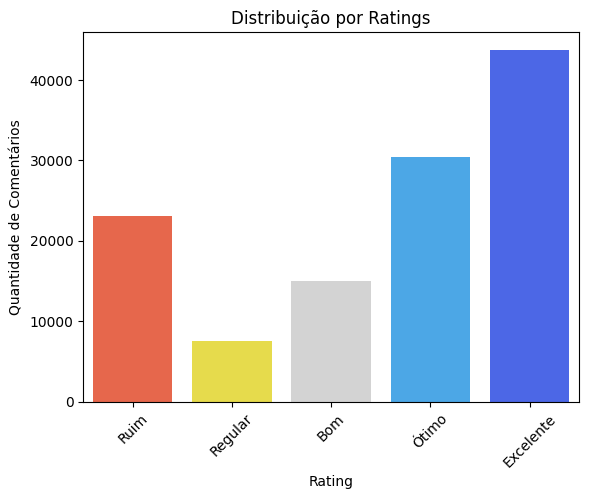

In [25]:
# Gráfico de Colunas que Apresenta a Distribuição dos Ratings

# Cria uma paleta de cores personalizada
custom_palette = sns.color_palette(["#FF5733", "#fff133", "#d3d3d3", "#33acff", "#3357FF"])

# Define the order for the x-axis categories
order = ["Ruim", "Regular", "Bom", "Ótimo", "Excelente"]

# Plota Gráfico com a ordem especificada
sns.countplot(x='customer_review_rating', data=development_sample, palette=custom_palette, order=order)
plt.title('Distribuição por Ratings')
plt.xlabel('Rating')
plt.ylabel('Quantidade de Comentários')
plt.xticks(rotation=45)  # Optional: Rotate x-axis labels for better readability
plt.show()

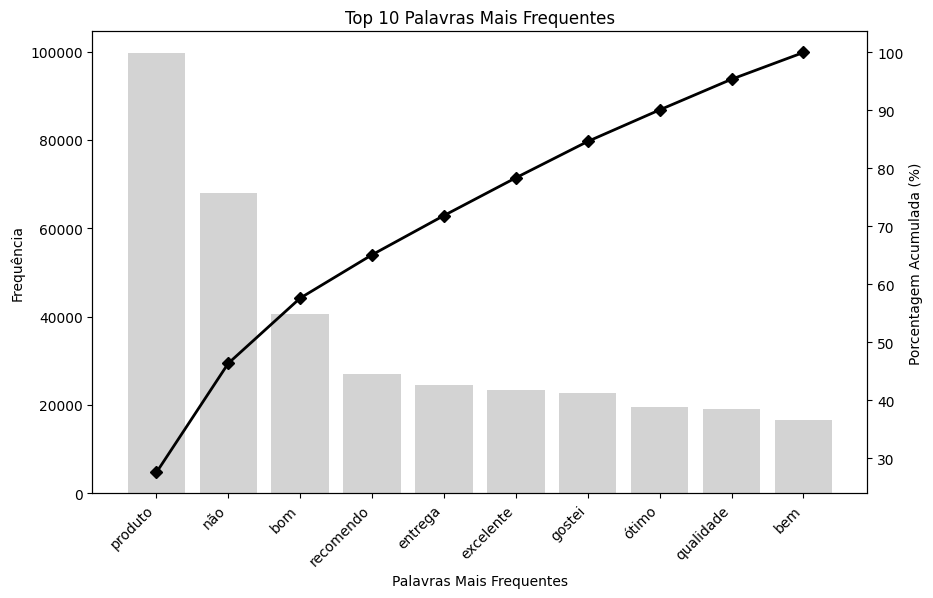

In [26]:
# Contar a frequência das palavras
all_tokens = [token for sublist in development_sample['review_text_tokenized'] for token in sublist]
word_freq = Counter(all_tokens)

# Pegar as 10 palavras mais frequentes
most_common_words = word_freq.most_common(10)

# Separar palavras e frequências
words, freqs = zip(*most_common_words)

# Calcular a porcentagem acumulada
freqs_cumsum = np.cumsum(freqs)  # Soma acumulada das frequências
total_freq = sum(freqs)  # Soma total das frequências
percent_cumsum = 100 * freqs_cumsum / total_freq  # Porcentagem acumulada

# Criar gráfico de Pareto
fig, ax1 = plt.subplots(figsize=(10, 6))

# Gráfico de barras para as frequências
ax1.bar(words, freqs, color='lightgray')
ax1.set_xlabel('Palavras Mais Frequentes')
ax1.set_ylabel('Frequência')
ax1.set_title('Top 10 Palavras Mais Frequentes')

# Adicionar o eixo secundário para a linha acumulada
ax2 = ax1.twinx()
ax2.plot(words, percent_cumsum, color='black', marker='D', linestyle='-', linewidth=2)
ax2.set_ylabel('Porcentagem Acumulada (%)', color='black')

# Ajustar as etiquetas do eixo X com rotação de 45 graus
ax1.set_xticks(range(len(words)))  # Define as posições no eixo X
ax1.set_xticklabels(words, rotation=45, ha='right')  # Rotaciona e ajusta o alinhamento

# Exibir o gráfico
plt.show()


<ipython-input-27-1ad1532f822a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  development_sample['review_length'] = development_sample['review_text_preprocessed'].apply(len)


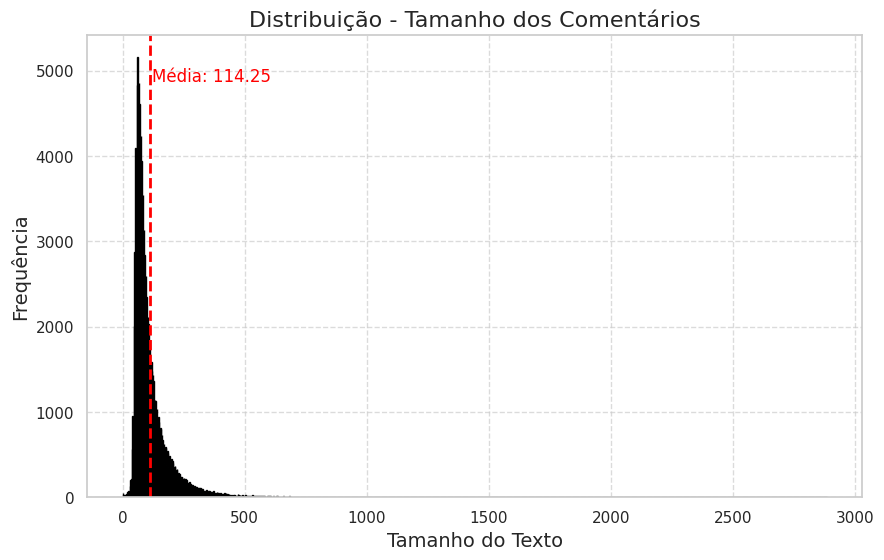

In [27]:
# Algumas estatísticas básicas sobre o tamanho de cada comentário
import matplotlib.pyplot as plt
import seaborn as sns

# Identifica tamanho do texto
development_sample['review_length'] = development_sample['review_text_preprocessed'].apply(len)

# Definir um estilo agradável para o gráfico
sns.set(style="whitegrid")

# Criar o histograma com melhorias visuais
plt.figure(figsize=(10, 6))  # Ajusta o tamanho do gráfico
ax = development_sample['review_length'].hist(bins='auto', edgecolor='black', color='skyblue')

# Adicionar título e rótulos
plt.title('Distribuição - Tamanho dos Comentários', fontsize=16)
plt.xlabel('Tamanho do Texto', fontsize=14)
plt.ylabel('Frequência', fontsize=14)

# Adicionar uma grade para facilitar a leitura
plt.grid(True, linestyle='--', alpha=0.7)

# Mostrar a linha de média
mean = development_sample['review_length'].mean()
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2)
plt.text(mean + 5, plt.ylim()[1] * 0.9, f'Média: {mean:.2f}', color = 'red', fontsize=12)

# Mostrar o gráfico
plt.show()


### 7ª Etapa: Inicia Processo de Lematização:



In [28]:
# No process de "Lematização" vamos buscar reduzir a palavra à sua raiz, retirando todas as inflexões e chegando ao lemma. Porém, essa redução sempre resultará em uma palavra que realmente existe na gramática, diferentemente do processo de "Stemming". Outro ponto importante é que, nessa técnica, a classe gramatical da palavra será levada em consideração para fazer a redução. Para trabalhos de "Análise de Sentimentos", onde a precisão e a compreensão do significado das palavras são essenciais, a "Lematização" é mais indicada que a técnica de "Stemming". A "Lematização" é capaz de manter o contexto e a integridade semântica, permitindo que o modelo entenda melhor os sentimentos expressos no texto. Vamos agora utilizar a biblioteca spaCy para aplicar essa técnica.

# Instala modelo de lematização em português do spaCy
!python -m spacy download pt_core_news_sm

# Carregando o modelo de lematização do spaCy para português
import spacy
nlp = spacy.load("pt_core_news_sm")

# Função para aplicar Lematização
def lemmatization(tokens):
    # Convert the list of tokens back into a string
    text = " ".join(tokens)
    doc = nlp(text)  # Processando o texto com o spaCy
    lemmatized_tokens = [token.lemma_ for token in doc]  # Extraindo as lemas de cada token
    return " ".join(lemmatized_tokens)  # Return as a string

# Aplicando a Lematização
development_sample['review_text_lemmatized'] = development_sample['review_text_tokenized'].apply(lemmatization)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 68.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


<ipython-input-28-82d2e87e8b64>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  development_sample['review_text_lemmatized'] = development_sample['review_text_tokenized'].apply(lemmatization)


In [29]:
display(HTML(development_sample.to_html(max_rows=20)))

,review_text,overall_rating,recommend_to_a_friend,site_category_lv1,site_category_lv2,review_title,reviewer_state,reviewer_gender,customer_review_text,review_text_preprocessed,customer_review_rating,tokens_list_tmp,review_text_tokenized,review_length,review_text_lemmatized
0,Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.,4,Yes,Informática,Notebook,Bom,RJ,F,Bom Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.,bom contente compra entrega rápida único problema americanas troca devolução produto consumidor problemas espera,Ótimo,"[bom, estou, contente, com, a, compra, entrega, rápida, o, único, problema, com, as, americanas, é, se, houver, troca, ou, devolução, do, produto, o, consumidor, tem, problemas, com, espera]","[bom, contente, compra, entrega, rápida, único, problema, americanas, troca, devolução, produto, consumidor, problemas, espera]",112,bom contente compra entregar rápido único problema americano troca devolução produto consumidor problema esperar
1,"Por apenas R$1994.20,eu consegui comprar esse lindo copo de acrílico.",4,Yes,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",SC,M,"Preço imbatível, ótima qualidade Por apenas R$1994.20,eu consegui comprar esse lindo copo de acrílico.",preço imbatível ótima qualidade apenas r consegui comprar lindo copo acrílico,Ótimo,"[preço, imbatível, ótima, qualidade, por, apenas, r, eu, consegui, comprar, esse, lindo, copo, de, acrílico]","[preço, imbatível, ótima, qualidade, apenas, r, consegui, comprar, lindo, copo, acrílico]",77,preço imbatível ótimo qualidade apenas elr conseguir comprar lir copo acrílico
2,"SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANELAS ELÉTRICAS. COSTUMO USAR OUTRA PANELA PARA COZIMENTO DE ARROZ (JAPONESA), MAS LEVA MUITO TEMPO, +/- 50 MINUTOS. NESSA PANELA É MUITO MAIS RÁPIDO, EXATAMENTE 6 MINUTOS. EU RECOMENDO.",4,Yes,Eletroportáteis,Panela Elétrica,ATENDE TODAS AS EXPECTATIVA.,SP,M,"ATENDE TODAS AS EXPECTATIVA. SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANELAS ELÉTRICAS. COSTUMO USAR OUTRA PANELA PARA COZIMENTO DE ARROZ (JAPONESA), MAS LEVA MUITO TEMPO, +/- 50 MINUTOS. NESSA PANELA É MUITO MAIS RÁPIDO, EXATAMENTE 6 MINUTOS. EU RECOMENDO.",atende todas expectativa supera agilidade praticidade outras panelas elétricas costumo usar outra panela cozimento arroz japonesa leva tempo minutos nessa panela rápido exatamente minutos recomendo,Ótimo,"[atende, todas, as, expectativa, supera, em, agilidade, e, praticidade, outras, panelas, elétricas, costumo, usar, outra, panela, para, cozimento, de, arroz, japonesa, mas, leva, muito, tempo, minutos, nessa, panela, é, muito, mais, rápido, exatamente, minutos, eu, recomendo]","[atende, todas, expectativa, supera, agilidade, praticidade, outras, panelas, elétricas, costumo, usar, outra, panela, cozimento, arroz, japonesa, leva, tempo, minutos, nessa, panela, rápido, exatamente, minutos, recomendo]",197,atender todo expectativa superar agilidader praticidade outro panela elétrica costumo usar outro panela cozimento arroz japonesa levar tempo minuto em esse panela rápido exatamente minuto recomer
3,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS DETALHES QUE TÊM!,4,Yes,Brinquedos,Veículos de Brinquedo,presente mais que desejado,SP,F,presente mais que desejado MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS DETALHES QUE TÊM!,presente desejado filho amou parece verdade tantos detalhes têm,Ótimo,"[presente, mais, que, desejado, meu, filho, amou, parece, de, verdade, com, tantos, detalhes, que, têm]","[presente, desejado, filho, amou, parece, verdade, tantos, detalhes, têm]",63,presente desejar filho amar parecer verdade tanto detalhe ter
4,"A entrega foi no prazo, as americanas estão de parabéns. A smart tv é muito boa, a navegação na internete e pelos aplicativos e excelente, não t

### 8ª Etapa: Definição do Target:

In [30]:
# O dataset apresenta o atributo "recommend_to_a_friend", o qual contempla os valores "Yes" ou "No". Estamos utilizando este atributo para definirmos a variável binária dependente, onde:
# Yes = 0
# No = 1
development_sample['target'] = development_sample['recommend_to_a_friend'].map({'Yes': 0, 'No': 1})

# Exibir as primeiras linhas do dataframe para verificar a nova variável 'target'
display(HTML(development_sample.to_html(max_rows=5)))


<ipython-input-30-64802ae43e3c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  development_sample['target'] = development_sample['recommend_to_a_friend'].map({'Yes': 0, 'No': 1})


,review_text,overall_rating,recommend_to_a_friend,site_category_lv1,site_category_lv2,review_title,reviewer_state,reviewer_gender,customer_review_text,review_text_preprocessed,customer_review_rating,tokens_list_tmp,review_text_tokenized,review_length,review_text_lemmatized,target
0,Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.,4,Yes,Informática,Notebook,Bom,RJ,F,Bom Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.,bom contente compra entrega rápida único problema americanas troca devolução produto consumidor problemas espera,Ótimo,"[bom, estou, contente, com, a, compra, entrega, rápida, o, único, problema, com, as, americanas, é, se, houver, troca, ou, devolução, do, produto, o, consumidor, tem, problemas, com, espera]","[bom, contente, compra, entrega, rápida, único, problema, americanas, troca, devolução, produto, consumidor, problemas, espera]",112,bom contente compra entregar rápido único problema americano troca devolução produto consumidor problema esperar,0
1,"Por apenas R$1994.20,eu consegui comprar esse lindo copo de acrílico.",4,Yes,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",SC,M,"Preço imbatível, ótima qualidade Por apenas R$1994.20,eu consegui comprar esse lindo copo de acrílico.",preço imbatível ótima qualidade apenas r consegui comprar lindo copo acrílico,Ótimo,"[preço, imbatível, ótima, qualidade, por, apenas, r, eu, consegui, comprar, esse, lindo, copo, de, acrílico]","[preço, imbatível, ótima, qualidade, apenas, r, consegui, comprar, lindo, copo, acrílico]",77,preço imbatível ótimo qualidade apenas elr conseguir comprar lir copo acrílico,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132371,"Material fraco, poderia ser melhor. Ficou devendo na minha opinião.",1,No,Papelaria,Material de Escritório,O produto não é bom.,RJ,M,"O produto não é bom. Material fraco, poderia ser melhor. Ficou devendo na minha opinião.",produto não bom material fraco poderia melhor ficou devendo opinião,Ruim,"[o, produto, não, é, bom, material, fraco, poderia, ser, melhor, ficou, devendo, na, minha, opinião]","[produto, não, bom, material, fraco, poderia, melhor, ficou, devendo, opinião]",67,produto não bom material fraco poder bom ficar dever opinião,1
132372,"Comprei esse produto, quando chegou estava com avaria. Devolvi, já vai fazer 3 meses, não me enviaram o produto e nem o estorno.",1,No,Decoração,Painel de Fotos,Produto não entregue,ES,F,"Produto não entregue Comprei esse produto, quando chegou estava com avaria. Devolvi, já vai fazer 3 meses, não me enviaram o produto e nem o estorno.",produto não entregue comprei produto chegou avaria devolvi vai fazer meses não enviaram produto estorno,Ruim,"[produto, não, entregue, comprei, esse, produto, quando, chegou, estava, com, avaria, devolvi, já, vai, fazer, meses, não, me, enviaram, o, produto, e, nem, o, estorno]","[produto, não, entregue, comprei, produto, chegou, avaria, devolvi, vai, fazer, meses, não, enviaram, produto, estorno]",103,produto não entregar comprei produto chegar avario devolvi ir fazer mês não enviar produto estorno,1


In [31]:
# Passo 2: Define 0 caminho onde o dataframe será salvo no Google Drive
save_path = '/content/drive/My Drive/ICMC/PLN/development_sample.pkl'

# Passo 3: Salva o dataframe utilizando pickle
development_sample.to_pickle(save_path)
print(f"DataFrame exportado com sucesso para {save_path}")

DataFrame exportado com sucesso para /content/drive/My Drive/ICMC/PLN/development_sample.pkl


### 9ª Etapa: Análise de Desbalanceamento

Contagem das classes:
target
0    88997
1    30759
Name: count, dtype: int64

Proporção das classes:
target
0    0.743153
1    0.256847
Name: proportion, dtype: float64


<ipython-input-32-102d47bc9559>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=development_sample, palette='viridis')


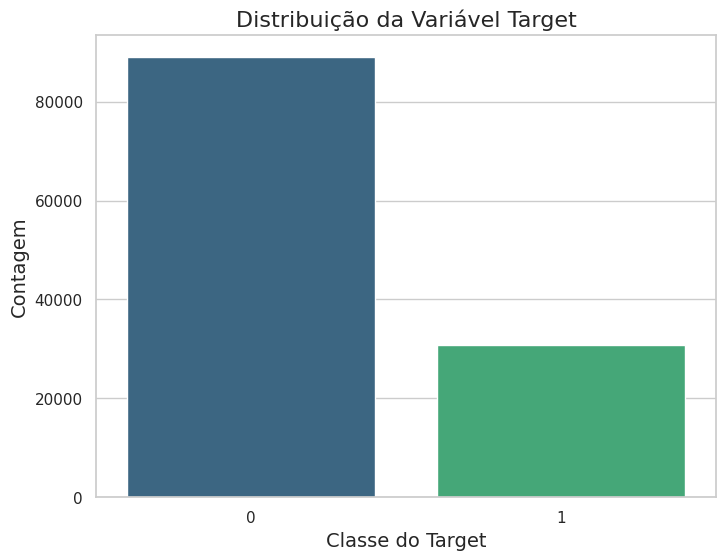

In [32]:
# Contar a frequência de cada valor na variável 'target'
class_counts = development_sample['target'].value_counts()

# Exibir as contagens
print("Contagem das classes:")
print(class_counts)

# Calcular a proporção de cada classe
class_proportions = development_sample['target'].value_counts(normalize=True)
print("\nProporção das classes:")
print(class_proportions)

# Plotar gráfico de barras para a distribuição das classes
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=development_sample, palette='viridis')

# Adicionar título e rótulos
plt.title('Distribuição da Variável Target', fontsize=16)
plt.xlabel('Classe do Target', fontsize=14)
plt.ylabel('Contagem', fontsize=14)

# Exibir o gráfico
plt.show()



### 10ª Etapa: Vetorizar Texto Utilizando o modelo Word2Vec

In [33]:
# Passo 1: Treinar o modelo Word2Vec
# Criar uma lista de listas de palavras
sentences = [text.split() for text in development_sample['review_text_lemmatized']]

# Treinar o modelo Word2Vec

#Parâmetros:

#a) sentences:

# Descrição: Este é um iterable (como uma lista de listas) onde cada sub-lista contém as palavras de uma frase (ou documento) tokenizadas.

# Objetivo: O modelo Word2Vec aprende a partir dessas frases, então a qualidade e a quantidade de dados que você fornece aqui são cruciais para o desempenho do modelo.

#b) vector_size:
# Descrição: Este parâmetro define o tamanho dos vetores de palavras que o modelo irá gerar. Por exemplo, vector_size=300 significa que cada palavra será representada por um vetor de 300 dimensões.

# Importância: Um vetor maior pode capturar mais nuances e informações sobre a palavra, mas também pode levar a um maior consumo de memória e tempo de treinamento. Tamanhos comuns são 100, 200 ou 300. Você pode experimentar diferentes tamanhos para ver qual funciona melhor para o seu conjunto de dados.

#c) window:

# Descrição: Este parâmetro define o tamanho da janela de contexto. Por exemplo, window=5 significa que o modelo considerará 10 palavras à esquerda e 10 palavras à direita da palavra-alvo para aprender a relação entre palavras.

# Importância: Um tamanho de janela maior pode ajudar a capturar relações de longo alcance entre palavras, enquanto uma janela menor pode se concentrar mais em relações imediatas. O valor ideal depende do tipo de dados e do contexto que você está modelando.

#d) min_count:

# Descrição: Este parâmetro especifica o número mínimo de ocorrências de uma palavra para que ela seja incluída no vocabulário. Por exemplo, min_count=1 significa que todas as palavras que aparecem pelo menos uma vez serão consideradas.

# Importância: Definir um valor maior (como 5 ou 10) pode ajudar a ignorar palavras raras ou ruído que não contribuem significativamente para o aprendizado do modelo. Isso pode melhorar a qualidade do modelo, reduzindo o tamanho do vocabulário e o tempo de treinamento.

#e) workers:

# Descrição: Este parâmetro define o número de threads a serem usadas durante o treinamento. Por exemplo, workers=4 significa que o modelo usará 4 threads para acelerar o processo de treinamento.

# Importância: Usar múltiplas threads pode acelerar significativamente o treinamento, especialmente em conjuntos de dados maiores. No entanto, o número ideal de threads pode depender do número de núcleos do seu processador.

model_w2v = Word2Vec(sentences, vector_size=300, window=10, min_count=1, workers=4)

# Passo 2: Representar os documentos como a média dos vetores de palavras
def document_vector(doc):
    # Remove palavras que não estão no modelo
    doc = [word for word in doc.split() if word in model_w2v.wv]
    return np.mean(model_w2v.wv[doc], axis=0) if doc else np.zeros(model_w2v.vector_size)

# Aplicar a função de vetorizar documentos
X = np.array([document_vector(text) for text in development_sample['review_text_lemmatized']])

# Passo 3: As labels (alvo) continuam sendo 'target'
y = development_sample['target']


### 11ª Etapa: Divisão dos dados - Treino e Teste

In [34]:
from sklearn.model_selection import train_test_split

# Dividir o dataset em treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificar a distribuição das classes antes do SMOTE
print(f'Distribuição original do treino:\n{y_train.value_counts()}')


Distribuição original do treino:
target
0    71109
1    24695
Name: count, dtype: int64


### 12ª Etapa: Balanceamento de Classes

In [35]:
from imblearn.over_sampling import SMOTE

# Aplicar SMOTE para balanceamento das classes
smote = SMOTE(random_state=42)

# Ajuste do modelo SMOTE com os dados de treino
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Verificar a nova distribuição das classes após o balanceamento
print(f'Distribuição após SMOTE:\n{y_train_resampled.value_counts()}')


Distribuição após SMOTE:
target
1    71109
0    71109
Name: count, dtype: int64


### 13ª Etapa: Treinar os Modelos

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# Instanciar os modelos

# a) Regressão Logística
logistic_regression_model = LogisticRegression(max_iter=200, random_state=42)

# b) Random Forest
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

# c) Gradient Boosting
gradient_boosting_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

#### Regressão Logística

In [37]:
import time

# Inicializa lista para computar o tempo de processamento de cada algoritmo
tempo_processamento = []


In [38]:
start_time = time.time()
logistic_regression_model.fit(X_train_resampled, y_train_resampled)
end_time = time.time()
tempo_processamento.append({"Modelo": "Regressão Logística", "Tempo de Processamento": end_time - start_time})

#### Random Forest

In [39]:
start_time = time.time()
random_forest_model.fit(X_train_resampled, y_train_resampled)
end_time = time.time()
tempo_processamento.append({"Modelo": "Random Forest", "Tempo de Processamento": end_time - start_time})

#### Gradient Boosting

In [40]:
start_time = time.time()
gradient_boosting_model.fit(X_train_resampled, y_train_resampled)
end_time = time.time()
tempo_processamento.append({"Modelo": "Gradient Boosting", "Tempo de Processamento": end_time - start_time})

#### Armazena Tempos de Processamento

In [41]:
# Armazena os tempos de processamento num dataframe
tempo_processamento_df = pd.DataFrame(tempo_processamento)

# Salvar os tempos de processamento para o Google Drive
save_path = '/content/drive/My Drive/ICMC/PLN/tempo_processamento.pkl'

# Salva o dataframe utilizando pickle
tempo_processamento_df.to_pickle(save_path)
print(f"DataFrame exportado com sucesso para {save_path}")

# Ler o DataFrame do arquivo pickle
tempo_processamento_df = pd.read_pickle(save_path)

# Mostrar os dados carregados
print("DataFrame carregado do Google Drive:")
print(tempo_processamento_df)

DataFrame exportado com sucesso para /content/drive/My Drive/ICMC/PLN/tempo_processamento.pkl
DataFrame carregado do Google Drive:
                Modelo  Tempo de Processamento
0  Regressão Logística               11.806525
1        Random Forest              846.522153
2    Gradient Boosting             3669.624630


#### Salva Modelo de Vetorização no Google Drive

In [42]:
# Salvando o modelo word2vec_model para uso futuro
from gensim.models import Word2Vec
from google.colab import drive

# Seta diretório raíz
drive.mount('/content/drive')

# Define a pasta do projeto
target_folder = "/content/drive/My Drive/ICMC/PLN"
target_file = f"{target_folder}/word2vec_model.bin"

# Assegura que o diretório existe. Se não, cria um diretório
import os
if not os.path.exists(target_folder):
    os.makedirs(target_folder)

# Salva o modelo model_w2v para o diretório definido
model_w2v.save(target_file)
print(f"Model saved to {target_file}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to /content/drive/My Drive/ICMC/PLN/word2vec_model.bin


#### Salva Modelos de Aprendizado de Máquina Supervisionado no Google Drive

In [43]:
import joblib

# Salva o Modelo de Regressão Logística Utilizando joblib
model_path = f"{target_folder}/logistic_regression_model.joblib"
joblib.dump(logistic_regression_model, model_path)

# Salva o Modelo de Random Forest Utilizando joblib
model_path = f"{target_folder}/random_forest_model.joblib"
joblib.dump(random_forest_model, model_path)

# Salva o Modelo de Gradient Boosting Utilizando joblib
model_path = f"{target_folder}/gradient_boosting_model.joblib"
joblib.dump(gradient_boosting_model, model_path)

['/content/drive/My Drive/ICMC/PLN/gradient_boosting_model.joblib']

### 14ª Etapa: Testar os Modelos Supervisionados

Resultados para Logistic Regression:
              precision    recall  f1-score   support

Positive (0)       0.97      0.90      0.94     17888
Negative (1)       0.76      0.93      0.83      6064

    accuracy                           0.91     23952
   macro avg       0.87      0.91      0.88     23952
weighted avg       0.92      0.91      0.91     23952

Resultados para Random Forest:
              precision    recall  f1-score   support

Positive (0)       0.96      0.93      0.94     17888
Negative (1)       0.80      0.88      0.84      6064

    accuracy                           0.91     23952
   macro avg       0.88      0.90      0.89     23952
weighted avg       0.92      0.91      0.92     23952

Resultados para Gradient Boosting:
              precision    recall  f1-score   support

Positive (0)       0.97      0.90      0.94     17888
Negative (1)       0.76      0.91      0.83      6064

    accuracy                           0.91     23952
   macro avg       0.87  

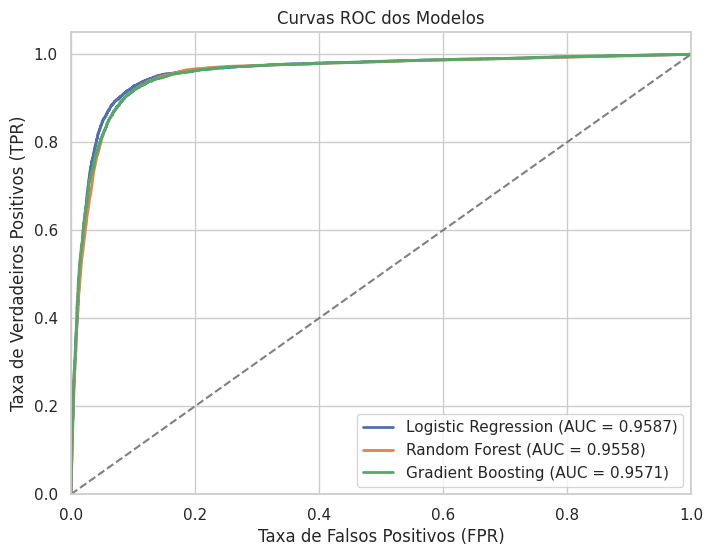

AUC Scores:
Logistic Regression: 0.9587
Random Forest: 0.9558
Gradient Boosting: 0.9571


In [44]:
# Fazer previsões e calcular probabilidades
models = {
    "Logistic Regression": logistic_regression_model,
    "Random Forest": random_forest_model,
    "Gradient Boosting": gradient_boosting_model
}

# Inicializar listas para armazenar os resultados
roc_auc_scores = {}
plt.figure(figsize=(8, 6))

# Avaliar todos os modelos
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # Probabilidade da classe positiva (1)

    # Gera relatório de classificação
    print(f"Resultados para {model_name}:")
    print(classification_report(y_test, y_pred, target_names=['Positive (0)', 'Negative (1)']))

    # Calcular a curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    roc_auc_scores[model_name] = roc_auc

    # Plotar a curva ROC
    plt.plot(fpr, tpr, lw=2, label=f"{model_name} (AUC = {roc_auc:.4f})")

# Configurações do gráfico
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Linha diagonal (classificador aleatório)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curvas ROC dos Modelos')
plt.legend(loc='lower right')
plt.show()

# Exibir AUC scores
print("AUC Scores:")
for model_name, auc_score in roc_auc_scores.items():
    print(f"{model_name}: {auc_score:.4f}")

### 15ª Etapa: Simular Classificação

In [45]:
# Supondo que o modelo de regressão logística já esteja treinado e o modelo Word2Vec já esteja ajustado.

# Nova frase para avaliação
sentence = "Eu não compraria este produto. estou insatisfeito"

# Função para calcular o vetor da nova frase
def preprocess_and_vectorize(sentence):
    # Tokenizar e fazer o pré-processamento (a mesma lógica que você usou para treinar)
    # Aqui você deve aplicar as mesmas etapas de pré-processamento que você usou para o conjunto de treino
    # Exemplo de tokenização e lematização (ajuste conforme seu processamento)
    words = sentence.split()  # Ajuste conforme seu método de tokenização
    words = [word for word in words if word in model_w2v.wv]  # Filtrar palavras que estão no modelo
    if words:
        return np.mean(model_w2v.wv[words], axis=0)
    else:
        return np.zeros(model_w2v.vector_size)

# Calcular o vetor para a nova frase
sentence_vector = preprocess_and_vectorize(sentence)

# Fazer a previsão
# Você precisa transformar o vetor em um formato que o modelo de regressão logística espera
# Aqui estamos usando uma matriz 2D com um único vetor
y_prob = logistic_regression_model.predict_proba([sentence_vector])[0]  # Probabilidades para a nova frase

# Definir a classe prevista
y_pred = logistic_regression_model.predict([sentence_vector])[0]

# Interpretação do resultado
sentiment = "Positivo" if y_pred == 0 else "Negativo"  # Ajuste conforme suas classes

# Exibir os resultados
print(f"Sentimento: {sentiment}")
print(f"Probabilidades: Positivo: {y_prob[0]:.4f}, Negativo: {y_prob[1]:.4f}")


Sentimento: Negativo
Probabilidades: Positivo: 0.0010, Negativo: 0.9990
